In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin

import shapely
from shapely.geometry import mapping

from coord import coord
from explode import explode
import matplotlib.pyplot as plt

In [2]:
#SET COUNTRY <----------------------------------------------------------------------------------CHANGE
n = 'ESP' 

#SET CRS #<-------------------------------------------------------------------------------------CHANGE
#crs = 'epsg:25830'
#crs = 'epsg:3003' #italy
#crs = 'epsg:2154' #france
crs = 'epsg:2062' #spain
wgs84= {'init' :'EPSG:4326'}

#open file
f = '../targets_0_sar/'
pts = gpd.read_file(f + 'sar_' + n + '.geojson')

#load search area and exclusion zones
f2 = '/Users/Zack/0_seawarden/'
search_area = gpd.read_file(f2 + '0_search_areas/4_search_area/search_area_100m_' + n + '.shp')
exclusion_zones = gpd.read_file(f2 + '0_search_areas/7_exclusions/' + n + '_exclusions.geojson')

#re-project layers
pts = pts.to_crs({'init': crs})
search_area = search_area.to_crs({'init': crs})
exclusion_zones = exclusion_zones.to_crs({'init': crs})

print('detections', len(pts), pts.crs)
print('search area', len(search_area), search_area.crs)
print('exclusion zones', len(exclusion_zones), exclusion_zones.crs)

detections 8424 {'init': 'epsg:2062'}
search area 1 {'init': 'epsg:2062'}
exclusion zones 9 {'init': 'epsg:2062'}


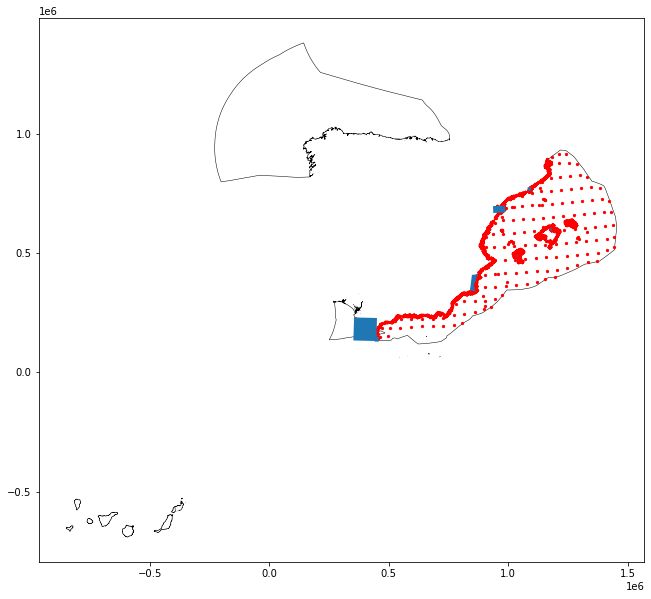

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
pts.plot(markersize=5, facecolor='red', ax=ax)
exclusion_zones.plot(ax=ax)

In [4]:
%%time 
#clip points to search area
clip = sjoin(pts, search_area, how='inner', op='within')
print('detections within search area:', len(clip))

detections within search area: 5115
Wall time: 734 ms


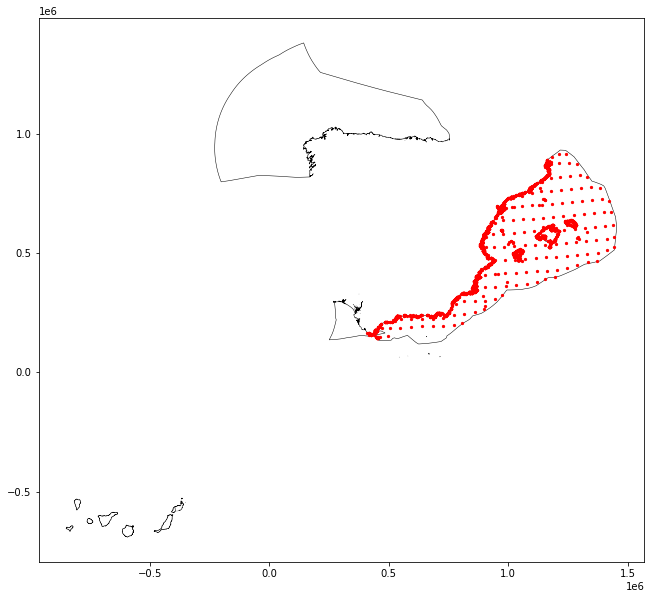

In [5]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
clip.plot(markersize=5, facecolor = 'red', ax=ax)

In [6]:
%%time 
#combine all exclusion zones
exclusion_zones['Dissolve'] = 0
exclusion_zones_dis = exclusion_zones.dissolve(by='Dissolve')

Wall time: 21 ms


In [7]:
%%time 
#exclude points in exclusion areas
mask = ~clip.within(exclusion_zones_dis.loc[0, 'geometry'])
clip2 = clip.loc[mask]
print('detections outside of exclusion zones:', len(clip2))

detections outside of exclusion zones: 2665
Wall time: 543 ms


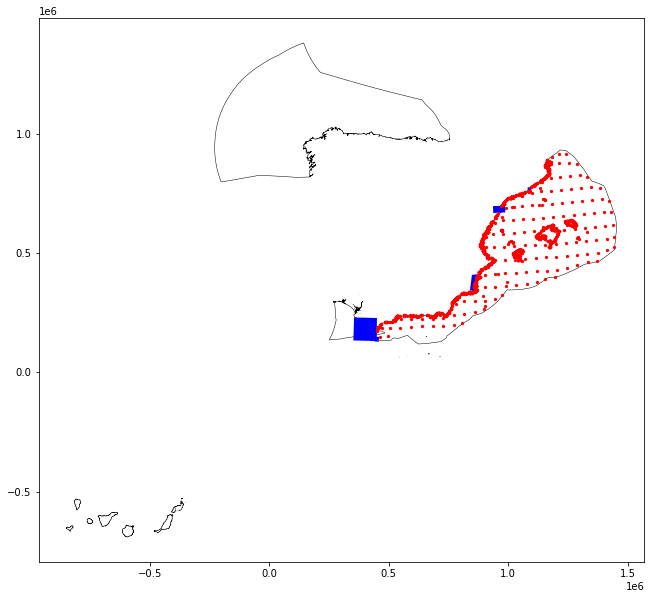

In [8]:
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
exclusion_zones_dis.plot(facecolor = 'blue', ax=ax)
clip2.plot(markersize=5, facecolor = 'red', ax=ax)

In [9]:
%%time 
#buffer points, dissolve buffers to aggregate points near each other
buffer = gpd.GeoDataFrame(geometry = clip2.buffer(10))
buffer['Dissolve'] = 0
buffer_dis = buffer.dissolve(by='Dissolve')

Wall time: 203 ms


In [10]:
%%time 
#explode polygon and generate centroids
buffer_exploded = explode(buffer_dis)      
centroids = gpd.GeoDataFrame(geometry = buffer_exploded.centroid)
print('detections after aggregation:', len(centroids))
centroids.crs = {'init' : crs}

detections after aggregation: 2647
Wall time: 1.15 s


In [11]:
%%time 
#buffer centroids and make square polygons
centroid_buffer = gpd.GeoDataFrame(geometry = centroids.buffer(500))
envelope = gpd.GeoDataFrame(geometry = centroid_buffer.envelope)
print(len(envelope))

2647
Wall time: 189 ms


In [12]:
%%time 
#aggregate overlapping envelopes
envelope['Dissolve'] = 0
envelope_dis = envelope.dissolve(by='Dissolve')
envelope_explode = explode(envelope_dis)   

#simplify aggregations to envelope
envelope_envelope = gpd.GeoDataFrame(geometry = envelope_explode.envelope)
envelope_envelope.shape

Wall time: 652 ms


(699, 1)

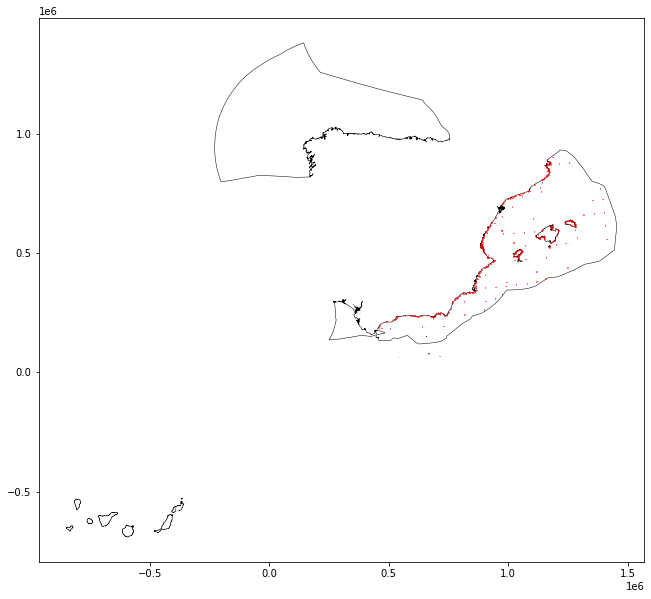

In [13]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
envelope_envelope.plot(linewidth=.5, edgecolor = 'red', facecolor = 'none', ax=ax)

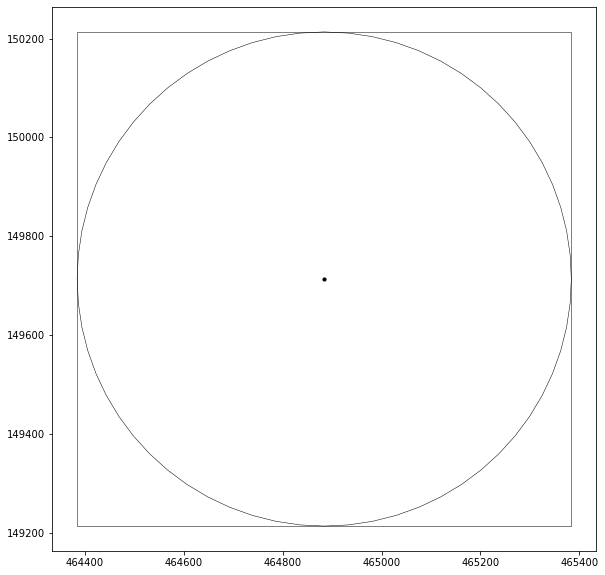

In [14]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = centroids.loc[[0], 'geometry'].plot(markersize=10, facecolor = 'black')
centroid_buffer.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)
envelope.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)

In [15]:
env = envelope_envelope.copy()
envelope_pts =  gpd.GeoDataFrame(geometry = env.centroid)
envelope_pts.crs = {'init' : crs}

env.crs = {'init' : crs}
env['geometry'] = env['geometry'].to_crs(epsg=4326)
print(env.crs)
env.head()

{'init': 'epsg:2062'}


,geometry
0,POLYGON ((-5.188754826367176 35.92689686637807...
1,"POLYGON ((-4.84828224863714 35.95840393042162,..."
2,POLYGON ((-5.360894442467767 36.15102019522206...
3,POLYGON ((-4.754167071689234 36.24317081643685...
4,POLYGON ((-5.295983610314768 36.25461154598311...


In [16]:
#extract lat/long for each square polygon (envelope)
coord_list = []
for i in range(len(env)):
    coords = mapping(env.geometry[i])['coordinates']
    coord_list.append(coords)

In [17]:
# #combine x/y point groups
coord_all = []
for i in range(len(coord_list)):
    coord_group = coord(coord_list[i]) #function to extract and format x/y points
    coord_group['id'] = i
    coord_all.append(coord_group) 
targets = pd.concat(coord_all)
print('total coordinates (5 per detection):', len(targets))
targets.head()

total coordinates (5 per detection): 3495


,x,y,id
0,-5.188754826367176,35.92689686637807,0
1,-5.177690233419902,35.927047854194875,0
2,-5.177875198330865,35.936047702995396,0
3,-5.188941164521078,35.935896695031275,0
4,-5.188754826367176,35.92689686637807,0


In [18]:
envelope = envelope_envelope
envelope.crs = {'init' : crs}
envelope.head()

,geometry
0,"POLYGON ((464384.0364686305 149213.3437733509,..."
1,"POLYGON ((495193.2173361282 152254.1053225877,..."
2,"POLYGON ((449298.2252215552 174382.7062060289,..."
3,"POLYGON ((504072.0069802073 183777.1831097524,..."
4,"POLYGON ((455352.3745876608 185778.8571934371,..."


In [19]:
targets.to_csv(f2 + n + '.csv', index = None, header=True)

#all SAR predictions
pts.to_file(f2 + n + '_sar_pts.shp')
pts['geometry'] = pts['geometry'].to_crs(epsg=4326)
pts.to_file(f2 + n + '_sar_pts.geojson', driver='GeoJSON') #good

#aggregated SAR positions
centroids.to_file(f2 + n + '_sar_pts_v2.shp')
centroids['geometry'] = centroids['geometry'].to_crs(epsg=4326)
centroids.to_file(f2 + n + '_sar_pts_v2.geojson', driver='GeoJSON') #good

# #envelope points
envelope_pts.to_file(f2 + n + '_sar_envelope_pts.shp') 
envelope_pts['geometry'] = envelope_pts['geometry'].to_crs(epsg=4326)
envelope_pts.to_file(f2 + n + '_sar_envelope_pts.geojson', driver='GeoJSON') #good

#envelopes
envelope.to_file(f2 + n + '_sar_envelope.shp') #good
envelope['geometry'] = envelope['geometry'].to_crs(epsg=4326)
envelope.to_file(f2 + n + '_sar_envelope.geojson', driver='GeoJSON') #good